In [1]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm)

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

In [2]:
numpy.set_printoptions(linewidth = 200)

shots = 8192 * 24

qubits = 6

# # should be "GHZ", "cascade", "dense", or "clustered"
# circuit_type = "GHZ"
# layers = 1 # number of gate layers

# qubits = 6 # number of qubits
# frag_num = 2 # number of fragments

simulation_backend = "qasm_simulator"

seed = 0
print_circuits = True

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [4]:
device = provider.get_backend('ibm_hanoi')
device

<IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>

In [5]:
noisy_simulator = provider.get_backend('ibmq_qasm_simulator')

In [6]:
circuit = QuantumCircuit.from_qasm_file("qaoa5q_pauli.qasm")

In [7]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device)
print(noise_model)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.066944 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067196 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.066962 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['sx', 'id', 'measure', 'x', 'cx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('id', [15]), ('id', [16]), ('id', [17]), ('id', [18]), ('id', [19]), ('id', [20]), ('id', [21]), ('id', [22]), ('id', [23]), ('id', [24]), ('id', [25]), ('id', [26]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('sx', [5]), ('sx', [6]), ('sx', [7]), ('sx', [8]), ('sx', [9]), ('sx', [10]), ('sx', [11]), ('sx', [12]), ('sx', [13]), ('sx', [14]), ('sx', [15]), ('sx', [16]), ('sx', [17]), ('sx', [18]), ('sx', [19]), ('sx', [20]), ('sx', [21]), ('sx', [22]), ('sx', [23]), ('sx', [24]), ('sx', [25]), ('sx

In [8]:
help(noisy_simulator)

Help on IBMQSimulator in module qiskit.providers.ibmq.ibmqbackend object:

class IBMQSimulator(IBMQBackend)
 |  IBMQSimulator(configuration: Union[qiskit.providers.models.backendconfiguration.QasmBackendConfiguration, qiskit.providers.models.backendconfiguration.PulseBackendConfiguration], provider: 'accountprovider.AccountProvider', credentials: qiskit.providers.ibmq.credentials.credentials.Credentials, api_client: qiskit.providers.ibmq.api.clients.account.AccountClient) -> None
 |  
 |  Backend class interfacing with an IBM Quantum Experience simulator.
 |  
 |  Method resolution order:
 |      IBMQSimulator
 |      IBMQBackend
 |      qiskit.providers.basebackend.BaseBackend
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  properties(self, refresh: bool = False, datetime: Union[datetime.datetime, NoneType] = None) -> None
 |      Return ``None``, simulators do not have backend properties.
 |  
 |  run(self, qobj: Union[qiskit.qobj.qasm_qobj.QasmQobj, q

In [9]:
##########################################################################################
# build and cut a circuit
##########################################################################################

#circuit, cuts = ml.build_circuit_with_cuts(circuit_type, layers, qubits, frag_num, seed)

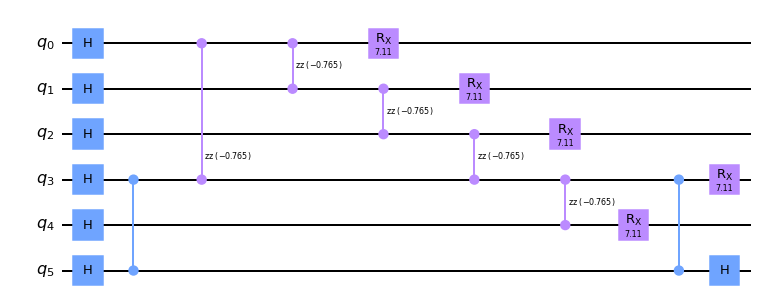

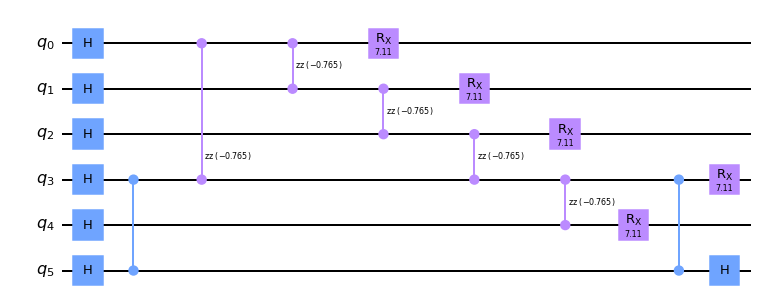

In [10]:
circuit.draw(output = 'mpl')

In [11]:
circuit.count_ops()

OrderedDict([('h', 7), ('rzz', 5), ('rx', 5), ('cz', 2)])

In [12]:
circuit.qubits[3]

Qubit(QuantumRegister(6, 'q'), 3)

In [13]:
cuts = [ (circuit.qubits[3], 2), (circuit.qubits[3], 5)]

In [14]:
print(cuts)

[(Qubit(QuantumRegister(6, 'q'), 3), 2), (Qubit(QuantumRegister(6, 'q'), 3), 5)]


In [15]:
fragments, wire_path_map = circuit_cutter.cut_circuit(circuit, cuts)

In [16]:
print(wire_path_map)

{Qubit(QuantumRegister(6, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 4)),), Qubit(QuantumRegister(6, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 0)),), Qubit(QuantumRegister(6, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 1)),), Qubit(QuantumRegister(6, 'q'), 3): ((1, Qubit(QuantumRegister(3, 'q'), 2)), (0, Qubit(QuantumRegister(5, 'q'), 2)), (1, Qubit(QuantumRegister(3, 'q'), 0))), Qubit(QuantumRegister(6, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 3)),), Qubit(QuantumRegister(6, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 1)),)}


In [17]:
total_variants = ml.fragment_variants(wire_path_map)

In [18]:
if print_circuits:
    print("total circuit:")
    print(circuit)
    print("cuts:")
    for cut in cuts:
        print("",cut)
    print()
    for idx, fragment in enumerate(fragments):
        print(f"fragment {idx}:")
        print(fragment)
        print()
    fragment_cuts = ml.fragment_cuts(wire_path_map)
    print("fragment_index, prep_cuts, meas_cuts:")
    for frag_idx, frag_cuts in enumerate(fragment_cuts):
        print(frag_idx, frag_cuts["prep"], frag_cuts["meas"])
    print()
    print("total number of fragment variants:", total_variants)
    print("total number of shots:", ( shots // total_variants ) * total_variants)
    print()

total circuit:
     ┌───┐                                  ┌────────────┐               »
q_0: ┤ H ├────■──────────────■──────────────┤ RX(7.1054) ├───────────────»
     ├───┤    │              │zz(-0.76459)  └────────────┘ ┌────────────┐»
q_1: ┤ H ├────┼──────────────■──────────────■──────────────┤ RX(7.1054) ├»
     ├───┤    │                             │zz(-0.76459)  └────────────┘»
q_2: ┤ H ├────┼─────────────────────────────■──────────────■─────────────»
     ├───┤    │zz(-0.76459)                                │zz(-0.76459) »
q_3: ┤ H ├─■──■────────────────────────────────────────────■─────────────»
     ├───┤ │                                                             »
q_4: ┤ H ├─┼─────────────────────────────────────────────────────────────»
     ├───┤ │                                                             »
q_5: ┤ H ├─■─────────────────────────────────────────────────────────────»
     └───┘                                                               »
«         

In [19]:
print(fragment_cuts)

[{'prep': 1, 'meas': 1}, {'prep': 1, 'meas': 1}]


In [20]:
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [21]:
print(all_bits)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']


In [22]:
# get the actual state / probability distribution for the full circuit
actual_state = ml.get_statevector(circuit)
actual_dist = { "".join(bits) : abs(amp)**2
                for bits, amp in zip(all_bits, actual_state)
                if amp != 0 }

# get a simulated probability distribution for the full circuit
circuit.measure_all()
full_circuit_result = ml.run_circuits(circuit, shots, backend = simulation_backend)
full_circuit_dist = {}
for part in full_circuit_result:
    for bits, counts in part.get_counts(circuit).items():
        if bits not in full_circuit_dist:
            full_circuit_dist[bits] = 0
        full_circuit_dist[bits] += counts / shots

In [23]:
circuit.draw()

┌───┐                                  ┌────────────┐               »
   q_0: ┤ H ├────■──────────────■──────────────┤ RX(7.1054) ├───────────────»
        ├───┤    │              │zz(-0.76459)  └────────────┘ ┌────────────┐»
   q_1: ┤ H ├────┼──────────────■──────────────■──────────────┤ RX(7.1054) ├»
        ├───┤    │                             │zz(-0.76459)  └────────────┘»
   q_2: ┤ H ├────┼─────────────────────────────■──────────────■─────────────»
        ├───┤    │zz(-0.76459)                                │zz(-0.76459) »
   q_3: ┤ H ├─■──■────────────────────────────────────────────■─────────────»
        ├───┤ │                                                             »
   q_4: ┤ H ├─┼─────────────────────────────────────────────────────────────»
        ├───┤ │                                                             »
   q_5: ┤ H ├─■─────────────────────────────────────────────────────────────»
        └───┘                                                               »
meas: 6/════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                       ░ ┌─┐               
«   q_0: ───────────────────────────────────────────────░─┤M├───────────────
«                                                       ░ └╥┘┌─┐            
«   q_1: ───────────────────────────────────────────────░──╫─┤M├────────────
«         ┌────────────┐                                ░  ║ └╥┘┌─┐         
«   q_2: ─┤ RX(7.1054) ├────────────────────────────────░──╫──╫─┤M├─────────
«         └────────────┘                 ┌────────────┐ ░  ║  ║ └╥┘┌─┐      
«   q_3: ─■────────────────────────────■─┤ RX(7.1054) ├─░──╫──╫──╫─┤M├──────
«         │zz(-0.76459) ┌────────────┐ │ └────────────┘ ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ─■─────────────┤ RX(7.1054) ├─┼────────────────░──╫──╫──╫──╫─┤M├───
«                       └────────────┘ │     ┌───┐      ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ──────────────────────────────■─────┤ H ├──────░──╫──╫──╫──╫──╫─┤M├
«                                            └───┘      ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/══════════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
«                                                          0  1  2  3  4  5

In [24]:
wire_path_map

{Qubit(QuantumRegister(6, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 4)),),
 Qubit(QuantumRegister(6, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 0)),),
 Qubit(QuantumRegister(6, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 1)),),
 Qubit(QuantumRegister(6, 'q'), 3): ((1, Qubit(QuantumRegister(3, 'q'), 2)),
  (0, Qubit(QuantumRegister(5, 'q'), 2)),
  (1, Qubit(QuantumRegister(3, 'q'), 0))),
 Qubit(QuantumRegister(6, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 3)),),
 Qubit(QuantumRegister(6, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 1)),)}

In [ ]:
##########################################################################################
# simulate fragments and recombine results to reconstruct the outputs of the full circuit
##########################################################################################

# simulate fragments, build fragment models, and recombine fragment models
frag_data0 = ml.collect_fragment_raw_data(fragments[0], 0, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = device)

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


Job Status: job is queued (11)    

In [ ]:
print(frag_data0)

In [ ]:
#run the circuit on a device
shots = 8192
job = execute([trans_qaoa, trans_pauli], backend=device, shots=shots)
job_monitor(job)
res = job.result()

In [27]:
frag_data1 = ml.collect_fragment_raw_data(fragments[1], 1, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = simulation_backend)

In [29]:
frag_targets = ml.identify_frag_targets(wire_path_map)

In [39]:
frag_data = [ ml.organize_tomography_data(frag_data0[0],
                                      frag_targets[0].get("prep"),
                                      frag_targets[0].get("meas"),
                                      prep_basis = "SIC"),
             ml.organize_tomography_data(frag_data1[0],
                                      frag_targets[1].get("prep"),
                                      frag_targets[1].get("meas"),
                                      prep_basis = "SIC")]

In [40]:
frag_data

[{'0000': {(('S0',), ('Zp',)): 15,
   (('S0',), ('Xp',)): 5,
   (('S0',), ('Xm',)): 12,
   (('S0',), ('Yp',)): 11,
   (('S0',), ('Ym',)): 12,
   (('S1',), ('Zp',)): 6,
   (('S1',), ('Zm',)): 235,
   (('S1',), ('Xp',)): 136,
   (('S1',), ('Xm',)): 110,
   (('S1',), ('Yp',)): 163,
   (('S1',), ('Ym',)): 93,
   (('S2',), ('Zp',)): 4,
   (('S2',), ('Zm',)): 255,
   (('S2',), ('Xp',)): 132,
   (('S2',), ('Xm',)): 115,
   (('S2',), ('Yp',)): 101,
   (('S2',), ('Ym',)): 187,
   (('S3',), ('Zp',)): 3,
   (('S3',), ('Zm',)): 257,
   (('S3',), ('Xp',)): 85,
   (('S3',), ('Xm',)): 162,
   (('S3',), ('Yp',)): 146,
   (('S3',), ('Ym',)): 110,
   (('S0',), ('Zm',)): 0},
  '0001': {(('S0',), ('Zp',)): 47,
   (('S0',), ('Xp',)): 26,
   (('S0',), ('Xm',)): 25,
   (('S0',), ('Yp',)): 24,
   (('S0',), ('Ym',)): 23,
   (('S1',), ('Zp',)): 13,
   (('S1',), ('Zm',)): 670,
   (('S1',), ('Xp',)): 429,
   (('S1',), ('Xm',)): 255,
   (('S1',), ('Yp',)): 233,
   (('S1',), ('Ym',)): 395,
   (('S2',), ('Zp',)): 19

In [41]:
direct_models = ml.direct_fragment_model(frag_data)
likely_models = ml.maximum_likelihood_model(direct_models)

direct_recombined_dist = ml.recombine_fragment_models(direct_models, wire_path_map)
likely_recombined_dist = ml.recombine_fragment_models(likely_models, wire_path_map)

In [42]:
direct_recombined_dist

{'000000': 0.007248058460737548,
 '100000': 6.542392767737331e-05,
 '001000': 0.01668094861216375,
 '101000': -0.000176623372471233,
 '000001': 0.005638330151559046,
 '100001': -0.0016072366437201206,
 '001001': 0.05803858129781998,
 '101001': 0.0005906573755688944,
 '000010': 0.00027835944492747214,
 '100010': -0.0008156412821985334,
 '001010': 0.17959138591079113,
 '101010': 0.0016097575302683605,
 '000011': 0.013835560543974145,
 '100011': -0.0006543952894368253,
 '001011': 0.014234054861433173,
 '101011': 0.0009610182861789938,
 '010000': 0.006756092421556049,
 '110000': -8.573965734928766e-05,
 '011000': 0.0034715207859719673,
 '111000': 0.00019372509573399458,
 '010001': 0.014357078162540383,
 '110001': -0.0007900086098574961,
 '011001': 0.01437508202065731,
 '111001': 0.0005912350416173369,
 '010010': 0.03502215598564121,
 '110010': -0.0005469508237547398,
 '011010': 0.06886846353332732,
 '111010': -0.00045254623123550564,
 '010011': 0.05951837381140712,
 '110011': -0.0010522339

In [43]:
actual_dist

{'000000': 0.007053859412640273,
 '000001': 0.004726524422385902,
 '000010': 0.002435759707287729,
 '000011': 0.014759189240811016,
 '000100': 0.0047265244223858955,
 '000101': 0.06704352845719859,
 '000110': 0.014759189240811023,
 '000111': 0.003256936160782964,
 '001000': 0.016240348372834442,
 '001001': 0.05790699263044281,
 '001010': 0.17917017205066388,
 '001011': 0.014115777803086904,
 '001100': 0.05790699263044283,
 '001101': 0.03439522965166949,
 '001110': 0.014115777803086907,
 '001111': 0.0073871979934698045,
 '010000': 0.007387197993469799,
 '010001': 0.01411577780308691,
 '010010': 0.03439522965166949,
 '010011': 0.05790699263044283,
 '010100': 0.014115777803086914,
 '010101': 0.17917017205066385,
 '010110': 0.05790699263044283,
 '010111': 0.016240348372834442,
 '011000': 0.0032569361607829622,
 '011001': 0.014759189240811009,
 '011010': 0.06704352845719856,
 '011011': 0.004726524422385905,
 '011100': 0.014759189240811012,
 '011101': 0.002435759707287737,
 '011110': 0.00472

In [44]:
# if qubits <= 5:
#     print()
#     print("actual probability distribution:")
#     for bits in all_bits:
#         try: print(bits, actual_dist[bits])
#         except: None

#     print()
#     print("'direct' recombined probability distribution:")
#     for bits in all_bits:
#         try: print(bits, direct_recombined_dist[bits])
#         except: None

#     print()
#     print("'likely' recombined probability distribution:")
#     for bits in all_bits:
#         try: print(bits, likely_recombined_dist[bits])
#         except: None

#     print()
#     print("full circuit probability distribution:")
#     for bits in all_bits:
#         try: print(bits, full_circuit_dist[bits])
#         except: None

# print()

def naive_fix(dist):
    norm = sum( value for value in dist.values() if value >= 0 )
    return { bits : value / norm for bits, value in dist.items() if value >= 0 }

direct_recombined_dist = naive_fix(direct_recombined_dist)

def fidelity(dist):
    fidelity = sum( numpy.sqrt(actual_dist[bits] * dist[bits], dtype = complex)
                    for bits in all_bits
                    if actual_dist.get(bits) and dist.get(bits) )**2
    return fidelity.real if fidelity.imag == 0 else fidelity

direct_fidelity = fidelity(direct_recombined_dist)
likely_fidelity = fidelity(likely_recombined_dist)
full_circuit_fidelity = fidelity(full_circuit_dist)
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)
print("full circuit fidelity:", full_circuit_fidelity)




'direct' distribution fidelity: 0.9890498121692942
'likely' distribution fidelity: 0.9866117261777232
full circuit fidelity: 0.9999382663757089
